In [150]:
import sys, os 
import numpy as np 
import pandas as pd
from src import utils, plots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import rcParams
from scipy.stats import sem , zscore, ttest_rel
default_font = 15
fs_title = 16
rcParams["font.family"] = "Arial"
rcParams["savefig.dpi"] = 300
rcParams["axes.spines.top"] = False
rcParams["axes.spines.right"] = False
rcParams["axes.titlelocation"] = "left"
rcParams["axes.titleweight"] = "normal"
rcParams["font.size"] = default_font
trial_type_palette = ['tab:green', 'tab:red', 'tab:cyan', 'tab:orange'] #rew #nrew #rew_test #nrew_test #GI

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [208]:
def proportion_licks(MouseObject, lick_window=(150,250)):
        '''
        returns a dictionary with the proportion of licks in a given window per each trial type

        Parameters
        ----------
        MouseObject : Mouse object
            Mouse object with loaded behavior
        lick_window : tuple, optional
            position window in which to count licks, by default (45,110)
        '''
        df = utils.get_lick_df(MouseObject, drop_last_trial=True)
        n_trials = int(df.trial.max())
        isrewarded = MouseObject._timeline['TrialRewardStrct'].flatten()[:n_trials]
        isnew = MouseObject._timeline['TrialNewTextureStrct'].flatten()[:n_trials]
        df = df.loc[df.flag != 1]
        prop_dict = {}
        df = df.loc[(df.distance >= lick_window[0]) & (df.distance < lick_window[1])]
        _ , counts = utils.get_trial_categories(isrewarded, isnew)
        for item in counts.items():
            if item[1] != 0:
                subdf = df.query(f"trial_type == '{item[0]}'")
                licks_in_trialtype = len(subdf.loc[:,'trial'].unique())
                prop_dict[item[0]] = licks_in_trialtype / item[1]
        return prop_dict

def plot_lickrates(lickrates, ax=None):
    from scipy.stats import sem
    colors = ['tab:green', 'tab:red']
    for cat in range(2):
        mean = lickrates[:,cat].mean(axis=0)
        sem_ = sem(lickrates[:,cat], axis=0)
        ax.plot(mean, label='rewarded', color=colors[cat])
        ax.fill_between(np.arange(400), mean-sem_, mean+sem_, color=colors[cat], alpha=0.3)
    ax.axvspan(0, 125, color='gray', alpha=0.3)
    ax.text(300,7.5, "category A", color='tab:green', ha='center', va='top', fontsize=15)
    ax.text(300,6.5, "category B", color='tab:red', ha='center', va='top', fontsize=15)
    ax.text(62.5, 8, "d' selection", color='k', ha='center', va='bottom', fontsize=15)
    ax.set_ylabel('lick rate (lick/s)')
    ax.set_xlabel('position (cm)')

def plot_firstlick_dist(all_first_lick, ax):
    ttypes_labels = ['Prototype A','rest of A']
    only_rew = all_first_lick.query("category == 'A'")
    only_rew_palette = ["tab:green", "tab:cyan"]
    sns.histplot(only_rew, x='distance', hue='trial_type', bins=20, alpha=0.3,
                kde=True, palette=trial_type_palette, ax=ax, hue_order=['rewarded', 'non rewarded', 'rewarded test', 'non rewarded test'],
                kde_kws={'clip': (0,300)}, legend=False)
    # add the means of each category 
    for itt, ttype in enumerate(['rewarded', 'rewarded test']):
        median = only_rew.query(f"trial_type == '{ttype}'")['distance'].median()
        ax.axvline(median, color=only_rew_palette[itt], linestyle='--', linewidth=1.5)
        ax.set_xlabel('first lick position (cm)')
        ax.set_xticks([0,150,250,300])
        ax.text(.7, .65-(itt*.05), ttypes_labels[itt], color=only_rew_palette[itt], transform=ax.transAxes)

def plot_centered_responses(overall_cd_lick_resp):
    fig, ax = plt.subplots(1, 4, figsize=(14, 3), sharey=True, sharex=True)
    centered_x = np.arange(overall_cd_lick_resp.shape[-1])
    avg_r_across_mice = np.nanmean(overall_cd_lick_resp, axis=0)
    sem_r_across_mice = sem(overall_cd_lick_resp, axis=0, nan_policy='omit')
    xticks = [0, (overall_cd_lick_resp.shape[-1] - 1)/2, overall_cd_lick_resp.shape[-1] - 1]
    window = 4
    ttypes_labels = ["Prototype A", "Prototype B", "rest of A", "rest of B"]

    for ia, area in enumerate(['V1', 'medial', 'lateral', 'anterior']):
        ax[ia].set_title(f'{area}')
        ax[ia].set_xlabel('time from first lick (s)')
        for it, ttype in enumerate(['rewarded', 'non rewarded', 'rewarded test', 'non rewarded test']):
            if ttype in ['rewarded', 'rewarded test']:
                avg_r = avg_r_across_mice[ia, 0, it]
                sem_r = sem_r_across_mice[ia, 0, it]
                ax[ia].plot(centered_x, avg_r, color=trial_type_palette[it], label=ttypes_labels[it])
                ax[ia].fill_between(centered_x, avg_r-sem_r, avg_r+sem_r, color=trial_type_palette[it], alpha=0.3)
                ax[ia].axvline((overall_cd_lick_resp.shape[-1] - 1)/2, color='k', linestyle='--', linewidth=0.5)
                ax[ia].hlines(0, 0, overall_cd_lick_resp.shape[-1], color='k', linestyle='--', linewidth=0.5)
                ax[ia].set_xticks(xticks,[-window, 0, window])
                ax[-1].text(.65, .8-(it*.05), ttypes_labels[it], color=trial_type_palette[it], transform=ax[-1].transAxes)
        ax[0].set_ylabel(f'Coding direction (a.u)')

def significance(pval):
    if pval >= 0.05:
        text =  "n.s."
    if pval < 0.05:
        text = "*"
    if (pval <= 0.01) & (pval >= 0.001):
        text = "**"
    if pval < 0.001:
        text = "***"
    return text

def plot_feature_comparison(feature, ylabel, ax):
    overall_A = feature[:,0,:125].mean(-1)
    overall_B = feature[:,1,:125].mean(-1)
    overall_A_sem = sem(overall_A, axis=0)
    overall_B_sem = sem(overall_B, axis=0)

    
    ax.errorbar(-.1, overall_A.mean(0), yerr=overall_A_sem, color='tab:green')
    ax.errorbar(.1, overall_B.mean(0), yerr=overall_B_sem, color='tab:red')
    ax.scatter(-.1, overall_A.mean(0), color='tab:green')
    ax.scatter(.1, overall_B.mean(0), color='tab:red')
    ax.set_ylabel(ylabel)
    ax.set_xticks([-.1,.1], ["Category A", "Category B"], rotation=45, ha='right');
    # connect dots 
    mouse_colors = sns.color_palette("Set2", 4)
    for animal in range(4):
        ax.plot([-.1,.1], [overall_A[animal], overall_B[animal]], color=mouse_colors[animal], alpha=0.8, zorder=0)
    t, p = ttest_rel(overall_A, overall_B)
    ptext = significance(p)
    ax.text(.5, 1, ptext, ha='center', va='center', transform=ax.transAxes)

# load data

In [162]:
motSVD0_percat = np.load("../data/overall/mean_motSVD0_per_cat.npy")
pupilarea_percat = np.load("../data/overall/mean_pupilarea_change_per_cat.npy")
speed_percat = np.load("../data/overall/mean_speed_per_cat.npy")
lickrate_percat = np.load("../data/overall/mean_lickrate_per_cat.npy")
overall_cd_lick_resp = np.load("../data/overall/overall_cd_licks_intime.npy")
all_first_lick =  pd.read_csv("../data/overall/all_first_lick.csv")
behavior_df = pd.read_csv("../data/overall/behavior_df.csv")
motion_change = np.load("../data/overall/mean_motion_change_per_cat.npy")
motion = np.load("../data/overall/mean_motion_per_cat.npy")

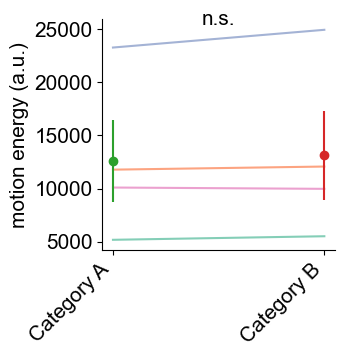

In [163]:
fig, ax  = plt.subplots(1,1, figsize=(3,3))
plot_feature_comparison(motion, "motion energy (a.u.)", ax)
plt.savefig("../results/motion_energy_comp.svg", bbox_inches='tight')

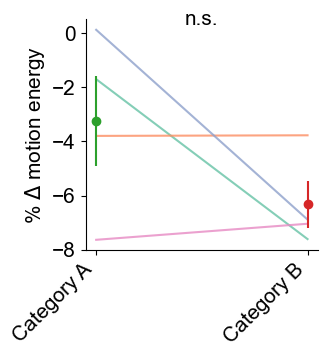

In [169]:
fig, ax  = plt.subplots(1,1, figsize=(3,3))
plot_feature_comparison(motion_change, "% $\Delta$ motion energy", ax)
plt.savefig("../results/motion_energy_change_comp.svg", bbox_inches='tight')

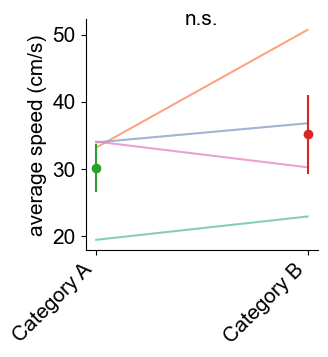

In [123]:
fig, ax  = plt.subplots(1,1, figsize=(3,3))
plot_feature_comparison(speed_percat, "average speed (cm/s)", ax)
plt.savefig("../results/speed_comparison.svg", bbox_inches='tight')

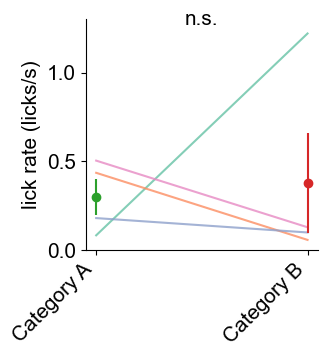

In [124]:
fig, ax  = plt.subplots(1,1, figsize=(3,3))
plot_feature_comparison(lickrate_percat, "lick rate (licks/s)", ax)
ax.set_ylim(0, 1.3)
plt.savefig("../results/lr_comparison.svg", bbox_inches='tight')

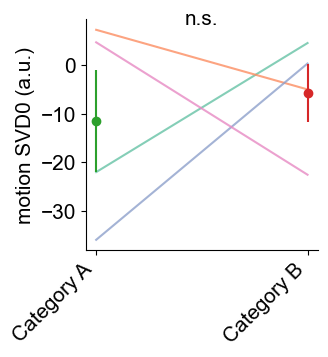

In [125]:
fig, ax  = plt.subplots(1,1, figsize=(3,3))
plot_feature_comparison(motSVD0_percat, "motion SVD0 (a.u.)", ax)
plt.savefig("../results/motsvd_comparison.svg", bbox_inches='tight')

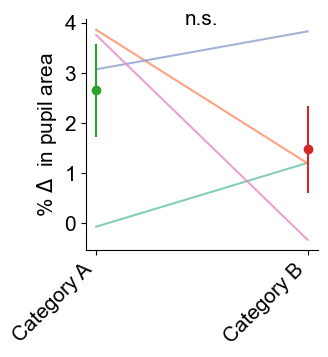

In [170]:
fig, ax  = plt.subplots(1,1, figsize=(3,3))
plot_feature_comparison(pupilarea_percat, "% $\Delta$  in pupil area", ax)
plt.savefig("../results/pupilarea_comparison.svg", bbox_inches='tight')

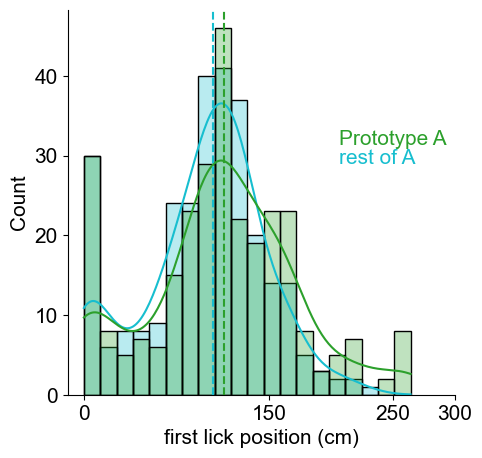

In [127]:
fig, ax  = plt.subplots(1,1, figsize=(5,5))
plot_firstlick_dist(all_first_lick, ax)
plt.savefig("../results/firstlick_dist.svg", bbox_inches='tight')

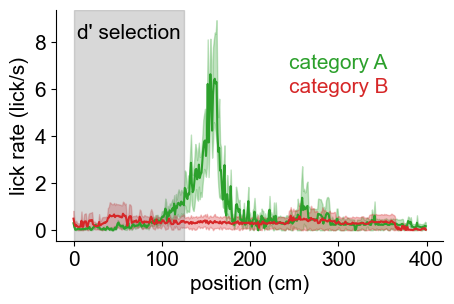

In [209]:
fig, ax  = plt.subplots(1,1, figsize=(5,3))
plot_lickrates(lickrate_percat, ax=ax)
plt.savefig("../results/lickrate_per_cat.svg", bbox_inches='tight', transparent=True)

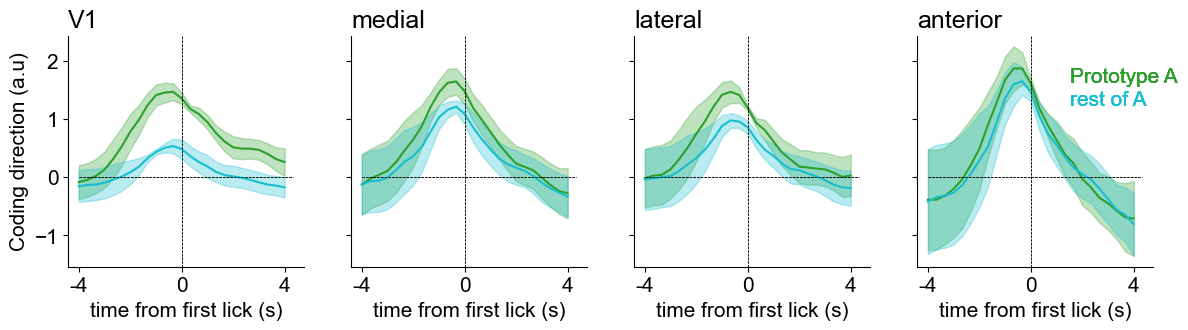

In [129]:
plot_centered_responses(overall_cd_lick_resp)
plt.savefig("../results/lick_centered_responses.svg", bbox_inches='tight', transparent=True)

In [203]:
def lick_averages(df, ax, lines=True, stat_test=False, alpha=1, offset=0, ylabel = True, **kwargs):
    from scipy import stats
    data = df[["rewarded", "non rewarded", "rewarded test", "non rewarded test"]]
    lick_rate = pd.melt(data, var_name="trial_type", value_name="lick_rate")
    lick_rate["trial_type"] = lick_rate["trial_type"].map({"rewarded": "Prototype A", "non rewarded": "Prototype B", "rewarded test": "Rest of A", "non rewarded test": "Rest of B"})
    if stat_test:
        #print(stats.f_oneway(data['rewarded'], data['non rewarded'], data['rewarded test'], data['non rewarded test']))
        import scikit_posthocs as sp
        res = sp.posthoc_ttest(lick_rate, val_col='lick_rate', group_col='trial_type', p_adjust='holm')
        #print(np.round(res,4))
    if lines:
        for i, row in data.iterrows():
            ax.plot([1, 2], [row['rewarded'], row['non rewarded']], '-', alpha=0.1, color='gray')
            ax.plot([3, 4], [row['rewarded test'], row['non rewarded test']], '-', alpha=0.1, color='gray')
    cmap = {"rewarded": 'tab:green', "non rewarded": 'tab:red', "rewarded test": 'tab:cyan', "non rewarded test": 'tab:orange'}
    for i, column in enumerate(['rewarded', 'non rewarded', 'rewarded test', 'non rewarded test'], start=1):
        mean = data[column].mean()
        median = data[column].median()
        c = cmap[column]
        ax.errorbar(i+offset, mean, yerr=stats.sem(data[column]), color=c, alpha=alpha, zorder=0)
        ax.plot(i+offset, median, '_', color=c, markersize=13, markeredgewidth=2, alpha=alpha, zorder=1)
        ax.plot(i+offset, mean, '8', color=c, markersize=10, markerfacecolor='white',  alpha=alpha, zorder=0)
    from matplotlib.lines import Line2D
    comparisons = [(0,1), (2,3)]
    xcoor = []
    ycoor = []
    pvals = []
    yval = 1
    for comp in comparisons:
        if res.iloc[comp[0], comp[1]] < 0.05:
            xcoor.append([comp[0]+1, comp[1]+1])
            ycoor.append(yval)
            yval += 0.03
            pvals.append(significance(res.iloc[comp[0], comp[1]]))
    #xcoor = [[1,4], [1,3], [1,2], [2,3], [3,4]]
    #ycoor = [1.14, 1.09, 1.04, 1.02, 1]
    fig = plt.gcf()
    lines = [Line2D(x, [y,y], color='k', linewidth=.5, transform=ax.transData, figure=fig) for x,y in zip(xcoor, ycoor)]
    for x,y,text in zip(xcoor, ycoor, pvals):
        ax.text(np.mean(x), y, text, ha='center', va='center', transform=ax.transData, fontsize=15)
    for line in lines:
        fig.add_artist(line)
    if ylabel:
        ax.set_ylabel("% trials with licks \n inside the reward region")
    ax.set_xticks([1, 2, 3, 4])
    if "xtickslabels" in kwargs:
        ax.set_xticklabels(kwargs["xtickslabels"])
    else:
        ax.set_xticklabels(["Prototype\nA", "Prototype\nB", "Rest of\ninstances\nA", "Rest of\ninstances\nB"])
    ax.set_yticks([0,.25, .5, .75, 1], [0, 25, 50, 75, 100])
    

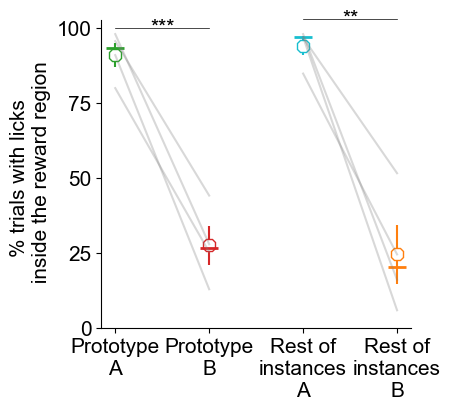

In [199]:
fig, ax = plt.subplots(1,1, figsize=(4,4))
lick_averages(behavior_df, ax, lines=True, stat_test=True, alpha=1)
plt.savefig("../results/behavior_performance.svg", bbox_inches='tight', transparent=True)

In [172]:
first100df = pd.read_csv(r"C:\Users\labadmin\Documents\GeneralizationPaper\Figure1\all_sessions_150_250_first100.csv", index_col=0)

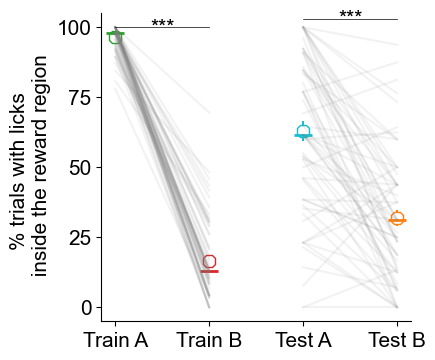

In [204]:
fig, ax = plt.subplots(1,1, figsize=(4,4))
lick_averages(first100df, ax, lines=True, stat_test=True, alpha=1, xtickslabels=["Train A", "Train B", "Test A", "Test B"])
plt.savefig("../results/behavior_performance_oneshot.svg", bbox_inches='tight', transparent=True)

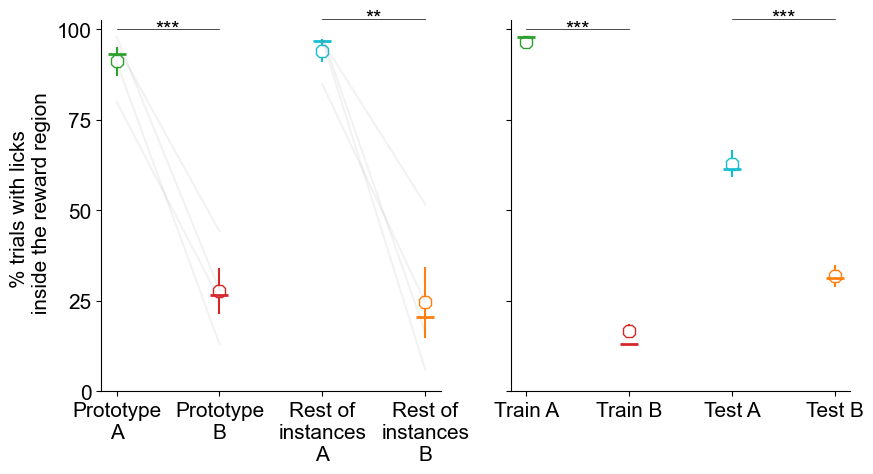

In [205]:
fig, ax = plt.subplots(1,2, figsize=(9,5), sharey=True)
lick_averages(behavior_df, ax[0], lines=True, stat_test=True, alpha=1)
lick_averages(first100df, ax[1], lines=False, stat_test=True, alpha=1 , xtickslabels=["Train A", "Train B", "Test A", "Test B"], ylabel=False)
plt.tight_layout()
plt.savefig("../results/category_vs_one.svg", bbox_inches='tight', transparent=True)